# Machine Learning

* This notebook evalutates standard classifiers from scikit-learn on the provided features selection.

In [1]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import pickle 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils
import sklearn.preprocessing
import sklearn.decomposition
import re
import folium

from folium.plugins import MarkerCluster
from matplotlib import cm
from scipy.stats import norm
from mpl_toolkits.basemap import Basemap

import utils
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.borderpad"] = 1
pallete_colors = cm.get_cmap('Set3', 16)
subset_size = "large"

In [2]:
AUDIO_DIR = os.environ.get('AUDIO_DIR',
                           'C:\\Users\\lrubio\\Desktop\\TFM\\tfm-mir\\data\\fma_small')

# Loading data created in first notebook and preporcessing
file_tracks =  open('../data/fma_metadata/tracks.pkl', 'rb') 
tracks = pickle.load(file_tracks)
file_features =  open('../data/fma_metadata/features.pkl', 'rb') 
features = pickle.load(file_features)
genres = utils.load('../data/fma_metadata/genres.csv')

tracks.shape, features.shape, genres.shape

((104343, 52), (104343, 518), (163, 4))

## Subset

In [3]:
subset = tracks.index[tracks['set', 'subset'] <= subset_size]

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

((104343, 52), (104343, 518))

In [4]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

82374 training examples, 10848 validation examples, 11121 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (161): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 170, 171, 172, 173, 174, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 377, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 444, 456, 465, 468, 491, 493, 495, 502, 504, 514, 524, 538, 539, 542, 567, 580, 602, 619, 651, 659, 693, 695, 741, 763

### Pre-processing

In [5]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False, pca_active=False):

    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']

    if(pca_active and len(columns) == 0):
        X_train = PCA(n_components=4,
                      whiten=True).fit_transform(
            features.loc[train].values)
        X_val = PCA(n_components=4,
                    whiten=True).fit_transform(
            features.loc[val].values)
        X_test = PCA(n_components=4,
                     whiten=True).fit_transform(
            features.loc[test].values)
    else:
        X_train = features.loc[train, columns].values
        X_val = features.loc[val, columns].values
        X_test = features.loc[test, columns].values

    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])

    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)

    return y_train, y_val, y_test, X_train, X_val, X_test

In [6]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False, pca_active=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
  
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val,y_test, X_train,X_val, X_test = pre_process(
            tracks, features_all, fset, multi_label, False, pca_active)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times


def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

## Variable selection

### PCA

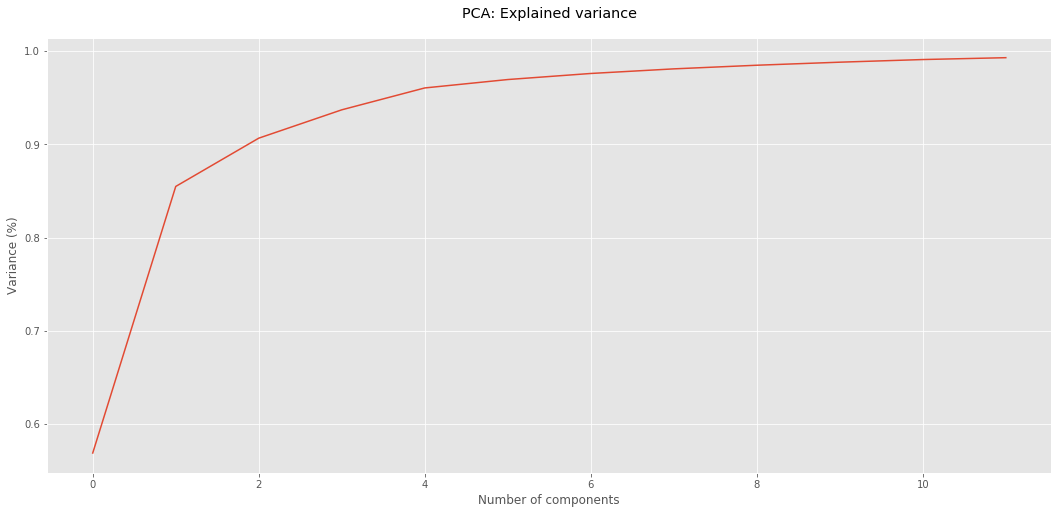

In [238]:
pca = PCA(n_components=12, whiten=True).fit(features.loc[train].values)

# Plotting Elbom Graph
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance (%)')
plt.title('PCA: Explained variance', pad=20)
plt.savefig('graphs/var-selection/pca-elbow.png');

# Using first 4 components
features_pca = PCA(n_components=4,
                   whiten=True).fit_transform(
                                features.loc[train].values)

### Radom Forest - Mean Decrease Accuracy (MDA)

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

y_train, y_val, y_test, X_train, X_val, X_test = pre_process(
    tracks, features, features.columns, False)
# Random forest as base
rf = RandomForestClassifier(max_depth=30, n_estimators=100, n_jobs=-1)
rf = rf.fit(X_train, y_train)
# Calculate PermutationImportance
perm = PermutationImportance(rf).fit(X_val, y_val)

In [ ]:
# Getting first 40 variables
d = eli5.explain_weights_df(perm, top=40)

col_names = pd.DataFrame(['_'.join(x) for x in features.columns],
                         columns=["variable"]).reset_index()
col_names['feature'] = col_names['index'].apply(lambda x: 'x' + str(x))
d = d.merge(col_names, on='feature')[['variable',
                                  'weight',
                                  'index']].sort_values('weight', ascending=False)

#Saving columns names
columns_mda = features.columns[[d['index']]]

file_cmda = open('../data/fma_metadata/columns_mda.pkl', 'wb') 
pickle.dump(columns_mda, file_cmda)

In [239]:
file_cmda =  open('../data/fma_metadata/columns_mda.pkl', 'rb') 
columns_mda = pickle.load(file_cmda)

## Multiple classifiers and feature sets

### Base model - Zero Rule

Lets start with a simplest model to compare results, this is: All data is categorized as the majority class. 

In [24]:
values = tracks.loc[test, ('track', 'genre_top')].value_counts()
total = values.sum()
values = round(values/total * 100, 2)

print(f"Base model is {values.loc['Experimental']}% of accuracy.")

Base model is 26.02% of accuracy.


### GRID of ML models

In [119]:
classifiers = {
    'LR': LogisticRegression(n_jobs=-1, solver="lbfgs"),
    'kNN': KNeighborsClassifier(n_neighbors=200, n_jobs=-1),
    'SVCrbf': SVC(kernel='rbf'),
    'linSVC2': LinearSVC(),
    'RF': RandomForestClassifier(max_depth=30, n_estimators=100,
                                 max_features=1, n_jobs=-1),
    'NB': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'XGB': XGBClassifier(max_depth=5, n_jobs=-1),
    'GBC': GradientBoostingClassifier(),
}
# Other excluded model
#'SVCpoly1': SVC(kernel='poly', degree=1),
#'AdaBoost': AdaBoostClassifier(n_estimators=10),

feature_sets = {}

for name in features.columns.levels[0]:
    feature_sets[name] = name

feature_sets_multi = {}
feature_sets_multi.update({
     'mfcc/contrast': ['mfcc', 'spectral_contrast'],
     'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
     'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
     'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
     'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
     'mfcc/contrast/chroma/centroid/rmse': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'rmse'],
    'all': list(features.columns.levels[0]),
    'columns_mda': columns_mda,
    'pca': []
})

In [ ]:
scores, times = test_classifiers_features(classifiers,
                                          feature_sets,
                                          False, True)

scores_matrix_simple = format_scores(scores)
time_matrix_simple = times.style.format('{:.4f}')

In [131]:
sm_s = open('../data/fma_metadata/scores_matrix_simple.pkl', 'wb') 
pickle.dump(scores_matrix_simple.data, sm_s)
tm_s = open('../data/fma_metadata/times_matrix_simple.pkl', 'wb') 
pickle.dump(time_matrix_simple.data, tm_s)

In [61]:
sm_s = open('../data/fma_metadata/scores_matrix_simple.pkl', 'rb')
scores_matrix_simple = pickle.load(sm_s)
tm_s = open('../data/fma_metadata/times_matrix_simple.pkl', 'rb')
time_matrix_simple = pickle.load(tm_s)

cm_d = scores_matrix_simple.columns.difference(['dim'])

scores_matrix_simple['mean'] = scores_matrix_simple[cm_d].mean(
    numeric_only=True, axis=1)
mean_c = pd.DataFrame(scores_matrix_simple[cm_d].mean(
    numeric_only=True, axis=0)).T
mean_c.index=["mean_algorithm"]

scores_matrix_simple['mean'] = np.round(scores_matrix_simple[cm_d].mean(
    numeric_only=True, axis=1) * 100, 2)

scores_matrix_simple = scores_matrix_simple.sort_values('mean', ascending=False)
scores_matrix_simple[cm_d ] = np.round(scores_matrix_simple[cm_d] * 100, 2)
ipd.display(scores_matrix_simple)

mean_c = mean_c.sort_values('mean_algorithm',  axis=1, ascending=False)
mean_c = np.round(mean_c * 100, 2)
ipd.display(mean_c)

time_matrix_simple = time_matrix_simple/60
ipd.display(time_matrix_simple.astype(float).round(2))

print (f"Total time excecution: {np.round(time_matrix_simple.sum().sum() / 60, 2)} hours")

,dim,LR,kNN,SVCrbf,linSVC2,RF,NB,QDA,XGB,GBC,mean
mfcc,140.0,42.31,42.37,46.45,42.06,42.79,23.97,24.73,45.32,44.12,39.35
spectral_contrast,49.0,36.99,38.05,42.57,36.89,39.83,24.89,20.10,41.30,40.09,35.64
spectral_centroid,7.0,30.95,35.39,35.42,30.77,33.80,19.98,22.01,36.32,35.47,31.12
zcr,7.0,30.27,34.66,34.69,30.44,33.26,22.28,22.53,36.00,35.38,31.06
spectral_rolloff,7.0,31.14,35.20,35.39,31.42,33.57,17.25,18.71,35.65,34.92,30.36
spectral_bandwidth,7.0,30.40,33.92,33.77,30.65,32.68,20.19,21.80,34.29,33.58,30.14
tonnetz,42.0,32.06,33.29,36.00,31.94,34.12,15.48,14.84,35.13,33.84,29.63
rmse,7.0,31.93,34.66,35.01,32.04,33.24,9.92,9.81,35.00,34.69,28.48
chroma_stft,84.0,32.96,34.56,37.74,33.25,35.65,1.95,2.17,37.87,36.34,28.05
chroma_cens,84.0,32.34,32.12,36.42,32.37,33.47,6.89,10.27,34.56,33.55,28.00


,SVCrbf,XGB,GBC,kNN,RF,linSVC2,LR,QDA,NB
mean_algorithm,37.26,36.98,35.99,35.09,35.05,32.87,32.82,15.36,14.96


,LR,kNN,SVCrbf,linSVC2,RF,NB,QDA,XGB,GBC
chroma_cens,0.07,10.66,55.01,12.24,0.59,0.02,0.04,18.02,40.30
chroma_cqt,0.04,8.94,37.42,9.42,0.59,0.02,0.04,18.37,39.77
chroma_stft,0.04,8.14,35.50,8.89,0.55,0.03,0.04,18.44,38.94
mfcc,0.06,13.52,44.32,11.28,0.55,0.04,0.07,34.60,55.64
rmse,0.02,0.19,7.60,2.73,0.50,0.00,0.00,1.75,10.20
spectral_bandwidth,0.01,0.16,10.05,3.05,0.54,0.00,0.00,2.04,10.55
spectral_centroid,0.01,0.14,8.92,3.05,0.53,0.00,0.00,2.02,10.52
spectral_contrast,0.02,5.61,20.48,6.08,0.52,0.01,0.02,12.13,30.59
spectral_rolloff,0.01,0.14,8.57,2.93,0.47,0.00,0.00,1.52,9.14
tonnetz,0.02,5.07,25.72,5.85,0.57,0.01,0.02,10.42,28.47


Total time excecution: 13.22 hours


In [ ]:
scores, times = test_classifiers_features(classifiers,
                                          feature_sets_multi,
                                          False, True)

scores_matrix_multi = format_scores(scores)
time_matrix_multi = times.style.format('{:.4f}')

In [ ]:
sm_m = open('../data/fma_metadata/scores_matrix_multi.pkl', 'wb') 
pickle.dump(scores_matrix_multi.data, sm_m)
tm_m = open('../data/fma_metadata/times_matrix_multi.pkl', 'wb') 
pickle.dump(time_matrix_multi.data, tm_m)

In [62]:
sm_m = open('../data/fma_metadata/scores_matrix_multi.pkl', 'rb')
scores_matrix_multi = pickle.load(sm_m)
tm_m = open('../data/fma_metadata/times_matrix_multi.pkl', 'rb')
time_matrix_multi = pickle.load(tm_m)

cm_d = scores_matrix_multi.columns.difference(['dim'])

mean_c = pd.DataFrame(scores_matrix_multi[cm_d].mean(
    numeric_only=True, axis=0)).T
mean_c.index=["mean_algorithm"]

scores_matrix_multi['mean'] = np.round(scores_matrix_multi[cm_d].mean(
    numeric_only=True, axis=1) * 100, 2)

scores_matrix_multi = scores_matrix_multi.sort_values('mean', ascending=False)
scores_matrix_multi[cm_d ] = np.round(scores_matrix_multi[cm_d] * 100, 2)
ipd.display(scores_matrix_multi)

mean_c = mean_c.sort_values('mean_algorithm',  axis=1, ascending=False)
mean_c = np.round(mean_c * 100, 2)

ipd.display(mean_c)

time_matrix_multi = time_matrix_multi / 60
ipd.display(time_matrix_multi.astype(float).round(2))

print (f"Total time excecution: {round(time_matrix_multi.sum().sum() / 60, 2)} hours")


,dim,LR,kNN,SVCrbf,linSVC2,RF,NB,QDA,XGB,mean
columns_mda,40.0,41.79,42.60,45.96,41.34,43.36,29.22,34.10,44.64,40.38
mfcc/contrast,189.0,44.31,42.24,48.30,43.84,43.49,24.75,27.97,46.95,40.23
mfcc/contrast/centroid,196.0,44.60,42.16,48.15,43.93,43.57,24.71,27.78,46.86,40.22
mfcc/contrast/chroma/centroid/tonnetz,322.0,45.90,41.49,49.11,45.21,42.41,20.74,27.96,47.78,40.08
mfcc/contrast/chroma/centroid/rmse,287.0,45.77,41.48,48.82,45.10,43.15,20.21,26.91,47.52,39.87
mfcc/contrast/chroma/centroid,280.0,45.31,41.26,48.47,44.41,42.27,20.53,27.27,47.28,39.60
mfcc/contrast/chroma,273.0,44.98,41.26,48.30,44.46,42.54,20.35,26.96,47.23,39.51
all,518.0,46.97,40.80,49.40,43.74,42.16,4.60,10.69,47.91,35.78
pca,4.0,23.51,24.13,24.83,23.58,21.37,23.96,24.03,24.49,23.74


,SVCrbf,XGB,LR,linSVC2,RF,kNN,QDA,NB
mean_algorithm,45.7,44.52,42.57,41.73,40.48,39.71,25.96,21.01


,LR,kNN,SVCrbf,linSVC2,RF,NB,QDA,XGB
mfcc/contrast,0.07,16.85,51.27,11.87,0.54,0.05,0.09,45.78
mfcc/contrast/chroma,0.11,24.50,73.10,15.03,0.56,0.07,0.16,67.78
mfcc/contrast/centroid,0.07,17.49,52.83,12.31,0.56,0.05,0.10,51.27
mfcc/contrast/chroma/centroid,0.11,24.87,75.13,15.45,0.56,0.07,0.16,70.62
mfcc/contrast/chroma/centroid/tonnetz,0.13,28.67,87.29,17.09,0.57,0.08,0.20,73.21
mfcc/contrast/chroma/centroid/rmse,0.11,25.93,77.01,15.54,0.56,0.08,0.18,64.30
all,0.22,41.10,128.33,26.65,0.62,0.15,0.45,118.42
columns_mda,0.03,4.89,17.59,6.22,0.52,0.01,0.02,10.08
pca,0.01,0.09,9.37,2.67,0.55,0.00,0.00,1.42


Total time excecution: 23.16 hours
